In [1]:
# Import what we need for the script.

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from EqW import *

In [2]:
# Create a function which generates a gaussian.

def gaussian(x, mu, sig, pwr):
    return pwr * (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))

In [3]:
# Define a continuum fit function.

def region_around_line(w, flux, cont, pf = 0):
    '''cut out and normalize flux around a line

    Parameters
    ----------
    w : 1 dim np.ndarray
        array of wanvelenghts
    flux : np.ndarray of shape (N, len(w))
        array of flux values for different spectra in the series
    cont : list of lists
        wavelengths for continuum normalization [[low1,up1],[low2, up2]]
        that described two areas on both sides of the line
    '''
    #index is true in the region where we fit the polynomial
    indcont = ((w > cont[0][0]) & (w < cont[0][1])) |((w > cont[1][0]) & (w < cont[1][1]))
    #index of the region we want to return
    indrange = (w > cont[0][0]) & (w < cont[1][1])
    fluxmean = np.mean(flux[:,np.where(indcont)])
    # make a flux array of shape
    # (nuber of spectra, number of pointsin indrange)
    f = np.zeros((flux.shape[0], indrange.sum()))
    for i in range(flux.shape[0]):
        # fit polynom of second order to the continuum region
        linecoeff = np.polyfit(w[indcont], flux[i, indcont], pf)
        # devide the flux by the polynom and put the result in our
        # new flux array
        f[i,:] = flux[i,indrange]/np.polyval(linecoeff, w[indrange])
    if fluxmean < 0:
        f = -f
    f = f - 1
    return w[indrange], f

In [4]:
# Define error functions for the optimisation of the gaussian fit. Penalise fits far from the Ha line using regularisation (check if this is appropriate).

def error(data, flux, wavelength):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    fit = gaussian(wavelength, mu, sig, pwr)
    return np.sum(np.power(flux - fit, 2.)) + 0.01 * np.power(mu - 6563, 2.)

def error2(data, flux, wavelength):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    fit = gaussian(wavelength, mu, sig, pwr)
    return np.power(flux - fit, 2.)

In [5]:
# Import the scipy.optimize.minimize function

from scipy.optimize import minimize

In [6]:
# Import SpectRes package to rebin the gaussian into the spectrum wavelength bins whilst conserving flux.

from spectres import spectres

In [7]:
# Define a new error function using SpectRes for the optimisation.

def reerr(data, w, f, gauw):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    res_fluxes = spectres(w, gauw, gaussian(gauw, mu, sig, pwr))
    return np.sum(np.power(f - res_fluxes, 2.)) + 0.1 * np.power(mu - 6563, 2.)

In [8]:
def halinefit(file, rang, quiet = False, cfit = 2):
    
    flux = np.load(file)
    wavelength = np.load('wavelength.npy')
    
    wha, fha = region_around_line(wavelength, np.reshape(flux, (1, np.size(flux))), rang, pf = cfit)
    fha = np.reshape(fha, np.size(wha))
    
    x0 = np.array((6563, 10, -5))
    gauw = np.linspace(rang[0][0]-10, rang[1][1]+10, 1000)
    res = minimize(reerr, x0, args=(wha, fha, gauw), method='Nelder-Mead', tol=1e-6)
    
    if not quiet:
        plt.plot(wha, fha)
        plt.plot(gauw, gaussian(gauw, res.x[0], res.x[1], res.x[2]))
    
    res_spec = spectres(wha, gauw, gaussian(gauw, res.x[0], res.x[1], res.x[2]))
    
    if not quiet:
        plt.show()
    
    cont = fha - res_spec
    
    if not quiet:
        plt.plot(wha, cont)
        plt.show()
    
    ew = (np.sum(gaussian(gauw, res.x[0], res.x[1], res.x[2]))/res.x[2])*(gauw[1]-gauw[0])
    
    snr = np.abs(res.x[2]) / np.std(cont)
    
    if not quiet:
        print(res.x)
    
        print(np.std(cont))
    
        print(snr)
        
    quans = np.quantile(cont, [0.05, 0.95])
    
    return ew, snr, quans[0], quans[1]
    

In [9]:
rang = [[6470, 6500],[6600, 6630]]

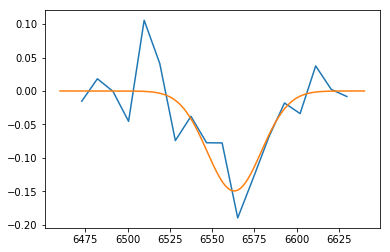

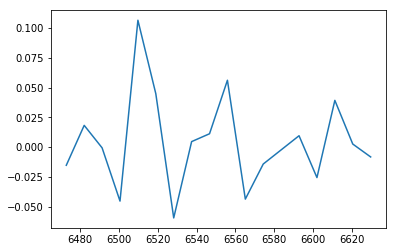

[ 6.56300331e+03  1.60071131e+01 -1.49403801e-01]
0.038649719957678685
3.8655855972251545


(40.123852880301826,
 3.8655855972251545,
 -0.04739066140722492,
 0.06363053142843497)

In [10]:
halinefit('v_e_20180704_32_1_0_2.npy', rang)

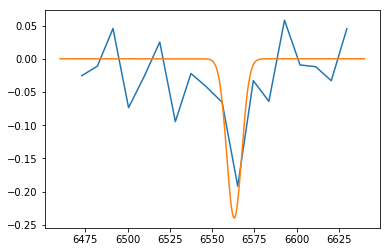

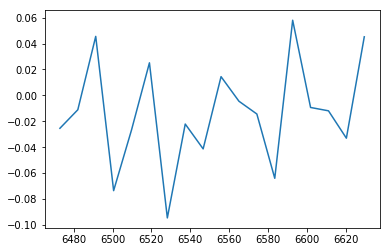

[ 6.56300459e+03  4.40967759e+00 -2.39524133e-01]
0.03993025757246872
5.998562172646527


(11.053422523370989,
 5.998562172646527,
 -0.07667749359599199,
 0.047426443506386376)

In [11]:
halinefit('v_e_20180704_32_2_0_2.npy', rang)

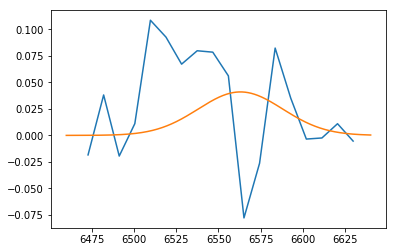

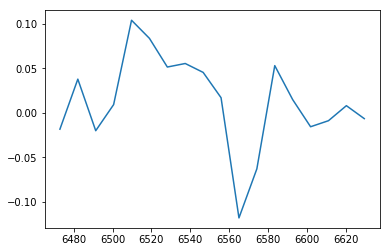

[6.56299755e+03 2.50000000e+01 4.09484145e-02]
0.05096009328405549
0.803538845398765


(62.60048145279982, 0.803538845398765, -0.071364989042021, 0.08682169799760174)

In [12]:
halinefit('v_e_20180704_32_3_0_2.npy', rang)

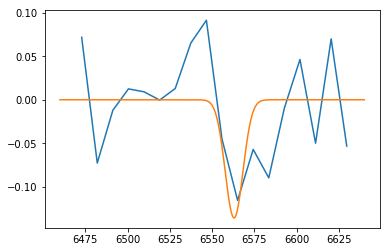

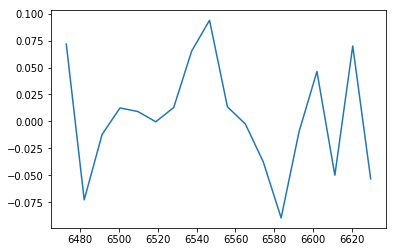

[ 6.56300544e+03  5.26267249e+00 -1.35868076e-01]
0.05049887407721117
2.6905169293724915


(13.191563655521614,
 2.6905169293724915,
 -0.07530921569845385,
 0.07511724166066891)

In [13]:
halinefit('v_e_20180704_38_1_0_2.npy', rang)

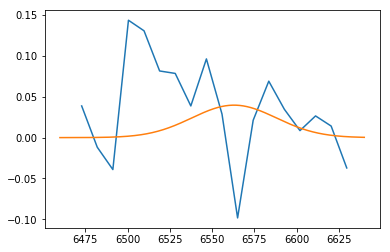

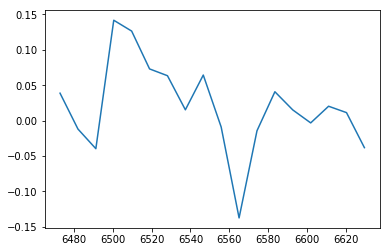

[6.56299802e+03 2.50000000e+01 3.97204407e-02]
0.061980912445521265
0.6408495633984178


(62.60047752124167,
 0.6408495633984178,
 -0.054446084806252265,
 0.12877510536731737)

In [14]:
halinefit('v_e_20180704_38_2_0_2.npy', rang)

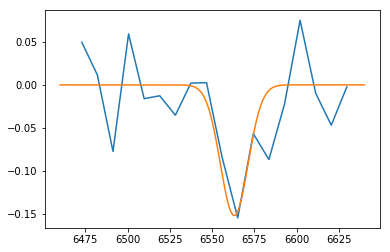

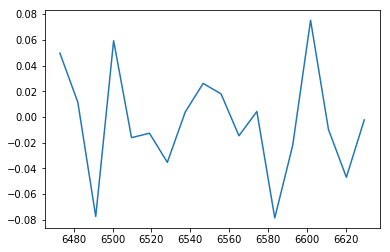

[ 6.56300519e+03  8.16803482e+00 -1.52003068e-01]
0.04040068624474585
3.7623882667677906


(20.47422703693004,
 3.7623882667677906,
 -0.07758819714525465,
 0.06170488383281498)

In [15]:
halinefit('v_e_20180704_38_3_0_2.npy', rang)